<h2>Transfer Learning with CNN for Classification</h2>
In the following lab we will train a depp NN for image classification using transfer learning.
We will use the CNN as a feature generator by only training the output layer

Libraries for OS and Cloud


In [2]:
import os
import copy
from datetime import datetime
from skillsnetwork import cvstudio

Libraries for Data Processing and Visualization


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
from tqdm import tqdm
import time

Deep Learning Libraries


In [4]:
import torch
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

Plot train cost and validation accuracy

In [5]:
def plot_data(COST, ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()

    plt.show()

Plot the transformed image

In [6]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.permute(1, 2, 0).numpy()
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

Compare the prediction and actual value

In [7]:
def result(model, x, y):
    z = model(x.unsqueeze_(0))
    _, yhat = torch.max(z.data, 1)

    if yhat.item() != y:
        text = "predicted: {} actual: {}".format(str(yhat.item()), y)
        print(text)

Define our device as the first visible cuda device if we have CUDA available

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cpu


## Load Data


In this section we will preprocess our dataset by changing the shape of the image, converting to tensor and normalizing the image channels
The dataset will be downloaded from CVStudio

In [9]:
cvstudioClient = cvstudio.CVStudio()
cvstudioClient.downloadAll()

100%|██████████| 205/205 [01:30<00:00,  2.26it/s]


In order to make our model more robust to common inconvenients, such as occlusion, extra data was included in the original dataset. The following to images were originally mis-classified by the model

(224, 224, 3)


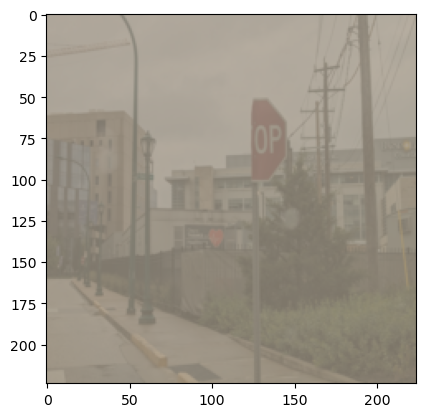

(224, 224, 3)


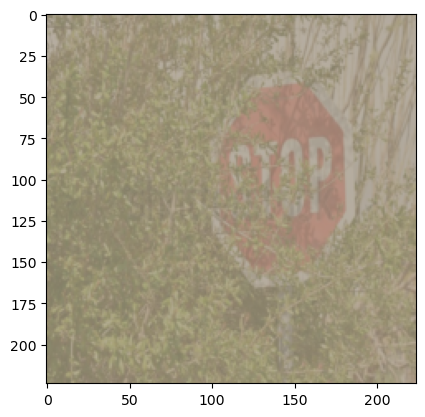

In [14]:
def showImage(imageName):
    image = Image.open(imageName)
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor()])
    x = transform(image)
    imshow_(x)


showImage('stop_half.jpeg')
showImage('stop_half_2.jpeg')

We will divide the dataset into both training and validation datasets, where 90% of samples will be used for training

In [15]:
percentage_train = 0.9
train_set = cvstudioClient.getDataset(train_test='train', percentage_train=percentage_train)
val_set = cvstudioClient.getDataset(train_test='test', percentage_train=percentage_train)

defult transform for pretrained model resnet18
this is the training set
defult transform for pretrained model resnet18
this is the test set


Lets plot some of our dataset

(224, 224, 3)


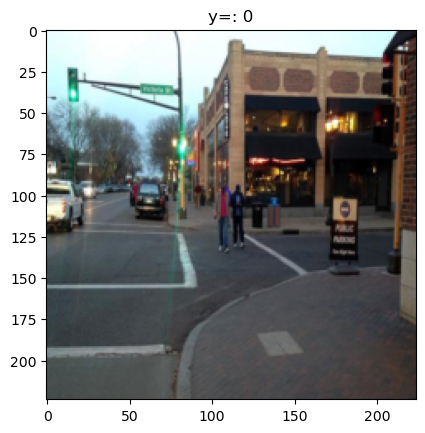

(224, 224, 3)


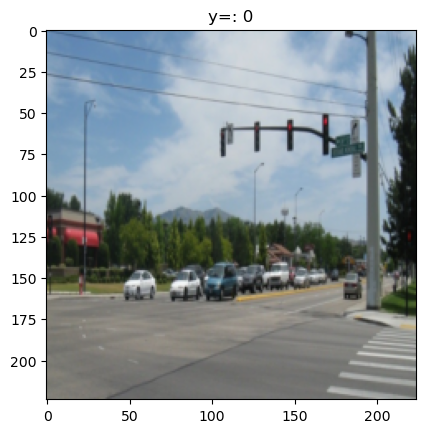

In [16]:
i = 0

for x, y in val_set:
    imshow_(x, "y=: {}".format(str(y.item())))
    i += 1
    if i == 2:
        break

(224, 224, 3)


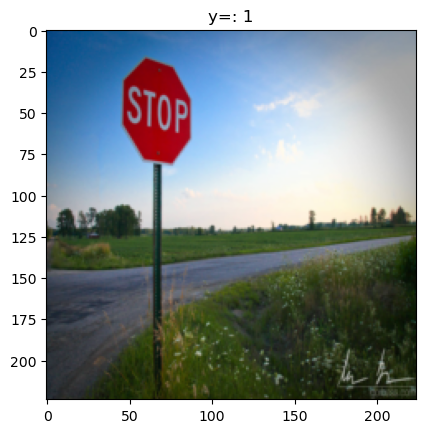

(224, 224, 3)


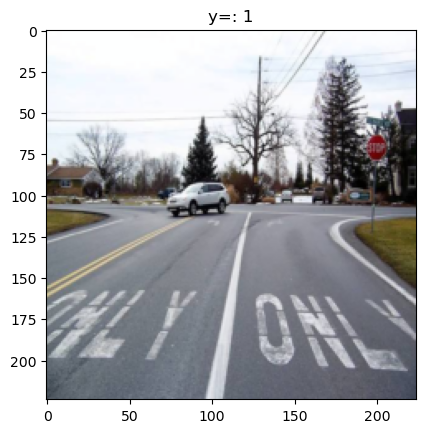

In [17]:
i = 0

for x, y in val_set:
    if (str(y.item()) == "1"):
        imshow_(x, "y=: {}".format(str(y.item())))
        i += 1
        if i == 2:
            break

## Defining hyperparameters

In [18]:
n_epochs = 20
batch_size = 32
lr = 0.000001
momentum = 0.9
# Using a learning rate scheduler will make the learning rate decay over time
lr_scheduler = True
base_lr = 0.001
max_lr = 0.01

# Load model and Train
The following function will train the model

In [19]:
def train_model(model, train_loader, validation_loader, criterion, optimizer,
                n_epochs, print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    n_test = len(val_set)
    accuracy_best = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in tqdm(range(n_epochs)):
        loss_sublist = []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            model.train()
            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch))

        scheduler.step()
        loss_list.append(np.mean(loss_sublist))
        correct = 0

        for x_test, y_test in validation_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy > accuracy_best:
            accuracy_best = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        if print_:
            print('learning rate', optimizer.param_groups[0]['lr'])
            print("Validation cost for epoch " + str(epoch + 1) + ": "
                  + str(np.mean(loss_sublist)))
            print("Validation accuracy for epoch " + str(epoch + 1) + ": "
                  + str(accuracy)) 
    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model

Lets load the pre-trained model resnet18

In [20]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Lets view the number of classes for our dataset

In [21]:
n_classes = train_set.n_classes
n_classes

2

We will replace the output layer of the model with a Linear object to discern between 2 classes

In [22]:
model.fc = nn.Linear(512, n_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Lets define a Cross-entropy loss object to measure the performance of out classification model, and an optimizer to update our model parameters

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=1)

We will be using cyclical learning rates

In [24]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001,
                                                  max_lr=0.01, step_size_up=5, mode="triangular2")

In [25]:
start_datetime = datetime.now()
start_time = time.time()

accuracy_list, loss_list, model = train_model(model, train_loader, validation_loader, criterion,
                                              optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 done


  5%|▌         | 1/20 [00:40<12:43, 40.20s/it]

learning rate 0.002800000000000002
Validation cost for epoch 1: 0.6570772528648376
Validation accuracy for epoch 1: 0.5238095238095238
epoch 1 done


 10%|█         | 2/20 [01:17<11:35, 38.62s/it]

learning rate 0.0046
Validation cost for epoch 2: 0.6344218899806341
Validation accuracy for epoch 2: 0.6666666666666666
epoch 2 done


 15%|█▌        | 3/20 [01:52<10:26, 36.88s/it]

learning rate 0.006400000000000001
Validation cost for epoch 3: 0.522865042090416
Validation accuracy for epoch 3: 0.7619047619047619
epoch 3 done


 20%|██        | 4/20 [02:24<09:21, 35.07s/it]

learning rate 0.008199999999999999
Validation cost for epoch 4: 0.31872450063625973
Validation accuracy for epoch 4: 0.8571428571428571
epoch 4 done


 25%|██▌       | 5/20 [02:59<08:43, 34.89s/it]

learning rate 0.010000000000000002
Validation cost for epoch 5: 0.21834376454353333
Validation accuracy for epoch 5: 0.8571428571428571
epoch 5 done


 30%|███       | 6/20 [03:33<08:02, 34.46s/it]

learning rate 0.008199999999999999
Validation cost for epoch 6: 0.2926473245024681
Validation accuracy for epoch 6: 0.7619047619047619
epoch 6 done


 35%|███▌      | 7/20 [04:06<07:24, 34.21s/it]

learning rate 0.006400000000000001
Validation cost for epoch 7: 0.2079145349562168
Validation accuracy for epoch 7: 0.7619047619047619
epoch 7 done


 40%|████      | 8/20 [04:37<06:36, 33.07s/it]

learning rate 0.0046
Validation cost for epoch 8: 0.3587983598311742
Validation accuracy for epoch 8: 0.9047619047619048
epoch 8 done


 45%|████▌     | 9/20 [05:04<05:45, 31.37s/it]

learning rate 0.002800000000000002
Validation cost for epoch 9: 0.20311380550265312
Validation accuracy for epoch 9: 0.9047619047619048
epoch 9 done


 50%|█████     | 10/20 [05:35<05:09, 30.99s/it]

learning rate 0.001
Validation cost for epoch 10: 0.1514859696229299
Validation accuracy for epoch 10: 0.7619047619047619
epoch 10 done


 55%|█████▌    | 11/20 [06:05<04:36, 30.77s/it]

learning rate 0.001900000000000001
Validation cost for epoch 11: 0.1700922635694345
Validation accuracy for epoch 11: 0.7619047619047619
epoch 11 done


 60%|██████    | 12/20 [06:34<04:02, 30.37s/it]

learning rate 0.002800000000000002
Validation cost for epoch 12: 0.1380457698057095
Validation accuracy for epoch 12: 0.9047619047619048
epoch 12 done


 65%|██████▌   | 13/20 [07:02<03:27, 29.65s/it]

learning rate 0.003699999999999999
Validation cost for epoch 13: 0.12847891884545484
Validation accuracy for epoch 13: 0.7619047619047619
epoch 13 done


 70%|███████   | 14/20 [07:31<02:56, 29.35s/it]

learning rate 0.0046
Validation cost for epoch 14: 0.15124733125170073
Validation accuracy for epoch 14: 0.9047619047619048
epoch 14 done


 75%|███████▌  | 15/20 [08:01<02:27, 29.49s/it]

learning rate 0.0055000000000000005
Validation cost for epoch 15: 0.2542082294821739
Validation accuracy for epoch 15: 0.9047619047619048
epoch 15 done


 80%|████████  | 16/20 [08:30<01:57, 29.30s/it]

learning rate 0.0046
Validation cost for epoch 16: 0.18689987808465958
Validation accuracy for epoch 16: 0.8571428571428571
epoch 16 done


 85%|████████▌ | 17/20 [08:59<01:28, 29.37s/it]

learning rate 0.003699999999999999
Validation cost for epoch 17: 0.12890822564562163
Validation accuracy for epoch 17: 0.8571428571428571
epoch 17 done


 90%|█████████ | 18/20 [09:30<00:59, 29.74s/it]

learning rate 0.002800000000000002
Validation cost for epoch 18: 0.12226154531041782
Validation accuracy for epoch 18: 0.8095238095238095
epoch 18 done


 95%|█████████▌| 19/20 [10:00<00:30, 30.02s/it]

learning rate 0.001900000000000001
Validation cost for epoch 19: 0.12663948411742845
Validation accuracy for epoch 19: 0.8571428571428571
epoch 19 done


100%|██████████| 20/20 [10:30<00:00, 31.53s/it]

learning rate 0.001
Validation cost for epoch 20: 0.13104495654503504
Validation accuracy for epoch 20: 0.8571428571428571
elapsed time 630.744576215744


The following snippet will report back the training results to CV Studio

In [26]:
parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum': momentum,
    'percentage used training': percentage_train,
    "learningRatescheduler": {"lr_scheduler": lr_scheduler,
                              "base_lr": base_lr, "max_lr": max_lr}
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime,
                               parameters=parameters, accuracy={'accuracy': accuracy_list, 'loss': loss_list })

if result.ok:
    print('Upload completed')

Upload completed


Lets save the model an also report it back to CV Studio

In [27]:
torch.save(model.state_dict(), 'model.pt')
result = cvstudioClient.uploadModel('model.pt', {'numClasses': n_classes})

File Uploaded


Now we plot train cost and validation accuracy with respect to each iteration

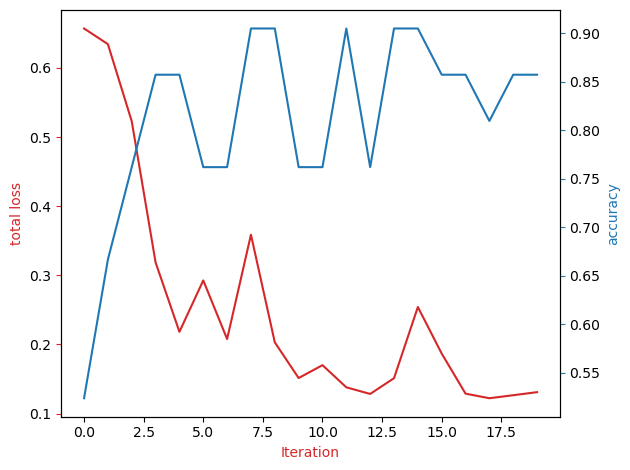

In [28]:
plot_data(loss_list, accuracy_list)

Load the model that performs best

In [29]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.load_state_dict(torch.load("model.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<code>showImage</code> is a helper function to display an image given its name

In [30]:
def showImage(imageName):
    image = Image.open(imageName)
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor()])
    x = transform(image)
    z = model(x.unsqueeze_(0))
    _, yhat = torch.max(z.data, 1)
    prediction = "Not Stop"
    if yhat == 1:
        prediction = "Stop"
    imshow_(transform(image), imageName+": Prediction = "+prediction)

(224, 224, 3)


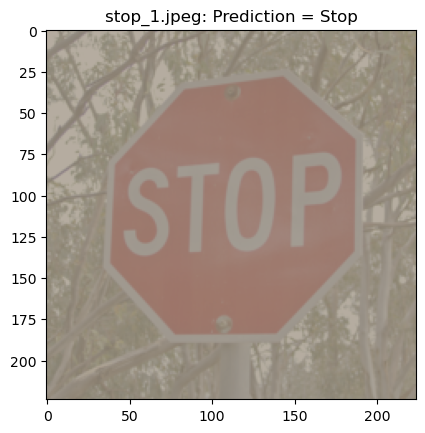

(224, 224, 3)


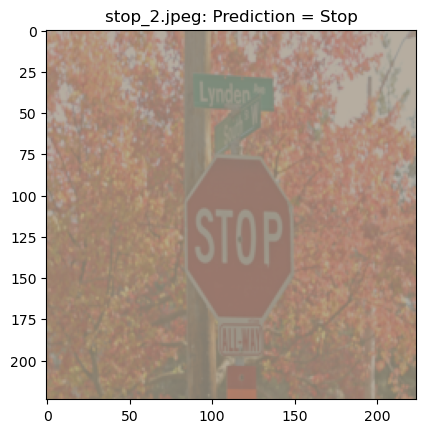

(224, 224, 3)


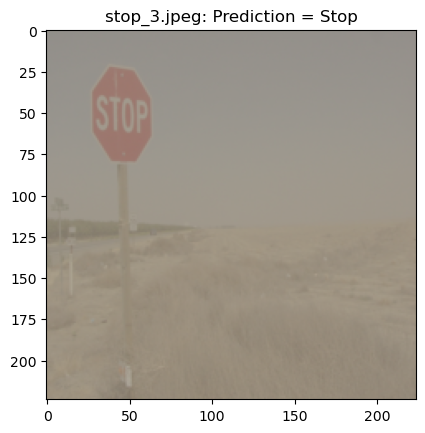

(224, 224, 3)


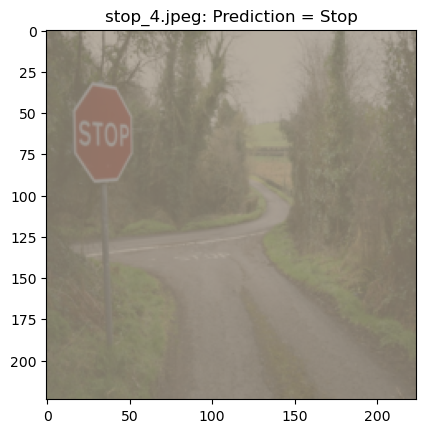

(224, 224, 3)


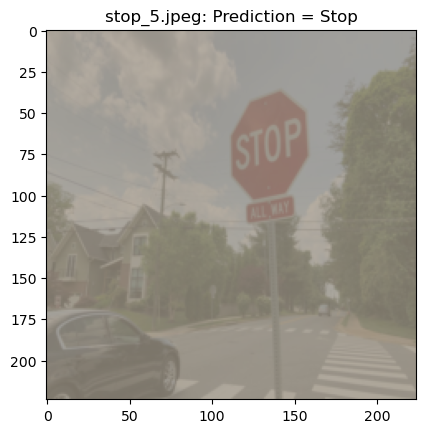

(224, 224, 3)


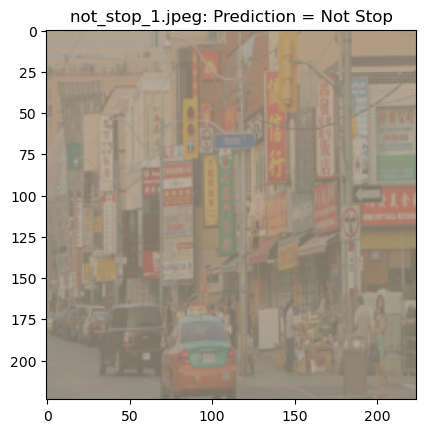

(224, 224, 3)


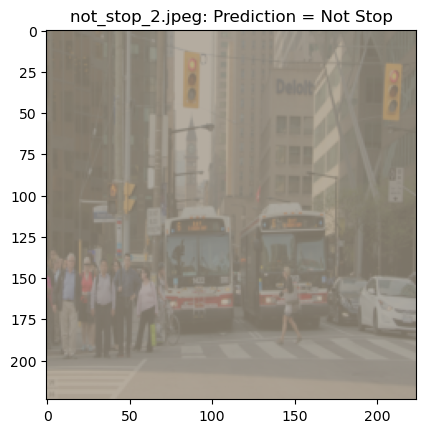

(224, 224, 3)


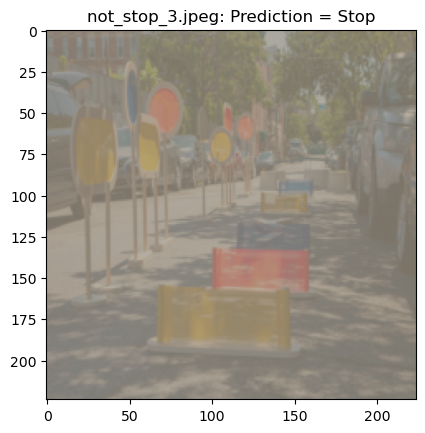

(224, 224, 3)


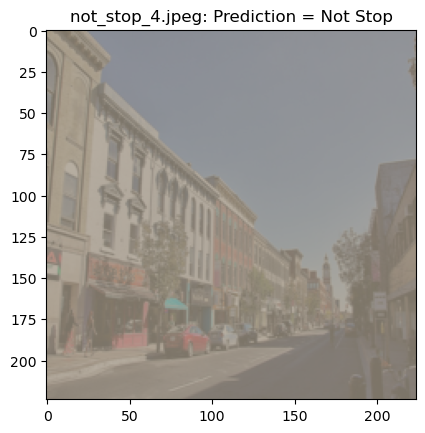

(224, 224, 3)


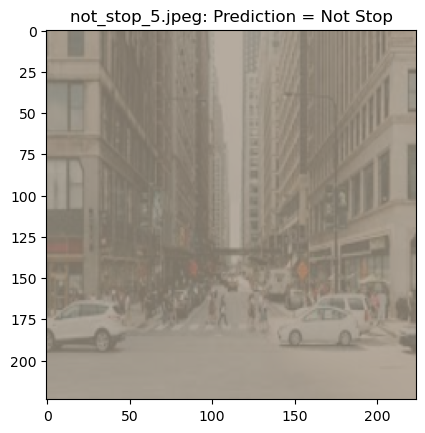

In [31]:
imageNames = ['stop_', 'not_stop_']
for namePrefix in imageNames:
    for i in range(5):
        imageName = namePrefix + str(i+1) + '.jpeg'
        showImage(imageName)

Now lets print the samples that were mis-classified before

(224, 224, 3)


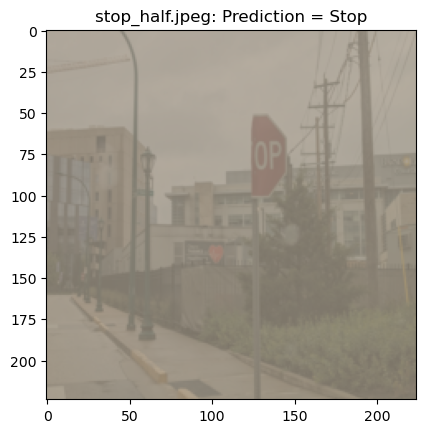

(224, 224, 3)


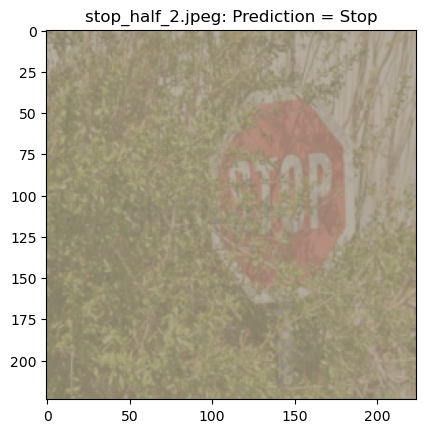

In [36]:
showImage('stop_half.jpeg')
showImage('stop_half_2.jpeg')